In [1]:
import numpy as np
import pandas as pd
import math
import json
import sys
import time

### data manipulation

In [2]:
def readFiles(filename):
    df = pd.read_csv(datafile, header=None)
    
    # restrictions are in first row
    restr = pd.to_numeric(df.iloc[0])
    
    # drop metadata columns
    df = df.drop([0], axis=0)
    
    return df, restr

In [32]:
def restrictdf(df, restr, setIndex=False, getDropped=False):
    # remove restricted cols and convert to numeric
    dropped=pd.DataFrame()
    for i, v in enumerate(df.columns):
        if restr[i] == 0 and setIndex:
            df = df.set_index(df.columns[i])
        elif restr[i] < 1:
            dropped[v] = df[v]
            df = df.drop(columns=[v])
        else:
            df[v] = pd.to_numeric(df[v], errors='coerce')
            
    # drop unknown values
    df = df.dropna()
    df = df[(df != '?').all(axis=1)]
    if getDropped:
        return df, dropped
    return df

In [4]:
# normalizes all columns
def normalizedf(indf):
    df=indf.copy()
    for c in df.columns:
        colMax = df[c].max()
        colMin = df[c].min()
        
        # probably no need to normalize if the values are very small. Might have to adjust the value
#         if colMax < 1:
#             continue
        df[c] = df[c].apply(lambda x: (x - colMin)/(colMax-colMin))
    return df

### helper functions

In [5]:
def euclideanDist(point, pointArray):
    return np.sqrt(np.sum((pointArray - point) ** 2, axis=1))

In [6]:
def initCentroids(numdf, k):
    return np.array(numdf.sample(k))

In [7]:
# pass a ***vectorized*** distance function: dist(point, pointArray)
# dataframe must be numeric other than last column
def assignCentroids(numdf, centroids, distfunc):
    if df.columns[-1] != 'cluster':
        df['cluster'] = -1
        
    for i, row in df.iloc[:,:-1].iterrows():
        df.at[i,'cluster'] = np.argmin(distfunc(row.values, centroids))
    return df

In [8]:
def reCalcCentroids(numdf, centroids):
    # centroid index is tag
    for i in range(len(centroids)):
        cluster = numdf[numdf['cluster'] == i]
        centroids[i] = np.mean(np.array(cluster.iloc[:,:-1]), axis=0)
    return centroids

In [9]:
def calcSSE(dfarray, c, distFunc):
    return np.sum(np.square(distFunc(c, dfarray)))

In [10]:
# takes labeled numeric df
def calcTotSSE(numdf, centroids, distFunc):
    totSSE=None
    for i, c in enumerate(centroids):
        cSSE = calcSSE(np.array(numdf[numdf['cluster'] == i].iloc[:,:-1]), c, distFunc)
        if totSSE is None:
            totSSE = cSSE
        else:
            totSSE += cSSE
    return totSSE

### kmeans 

In [11]:
def kmeans_lite(df, centroids, distFunc):
    df = assignCentroids(df, centroids, distFunc)
    prevSSE = calcTotSSE(df, centroids, distFunc)
    
    centroids = reCalcCentroids(df, centroids)
    df = assignCentroids(df, centroids, distFunc)
    currSSE = calcTotSSE(df, centroids, distFunc)
    
    counter = 0
    while counter < 10 and prevSSE - currSSE > 0.01:
        centroids = reCalcCentroids(df, centroids)
        df = assignCentroids(df, centroids, distFunc)
        prevSSE = currSSE
        currSSE = calcTotSSE(df, centroids, distFunc)
        counter += 1
    return df, centroids

### analytical functions

In [18]:
# takes numeric df with cluster labe
def analyzeClusters(df, centroids, distFunc):
    clusters=[]
    for i, c in enumerate(centroids):
        info = {}
        info["clusterID"] = i
        pnts = df[df['cluster'] == i]
        
        info["SSE"] = calcSSE(np.array(pnts.iloc[:,:-1]), c, distFunc)
        info["centroid"] = c
        
        dists = distFunc(c, np.array(pnts.iloc[:,:-1]))
        info["maxDistToCentroid"] = max(dists)
        info["minDistToCentroid"] = min(dists)
        info["avgDistToCentroid"] = np.sum(dists)/len(pnts)
        info["numPoints"] = len(pnts)
        info["dataPoints"] = pnts
        clusters.append(info)
    return clusters

In [44]:
def printClusterInfo(clusters, extraCols = None):
    for clusterInfo in clusters:
        for key in clusterInfo:
            if key == "dataPoints":
                if extraCols is not None:
                    clusterInfo[key] = clusterInfo[key].join(extraCols)
                print(f"{key}: \n{clusterInfo[key].to_markdown()}")
            else:
                print(f"{key}: {clusterInfo[key]}")
        print('\n')

### running

In [14]:
def hyperparams(df, restr, epsmin, epsmax, mptsmin, mptsmax):
    numeps = 5
    nummpts = 5
#     epsmin=0.001
#     epsmax=0.1
#     mptsmin=2
#     mptsmax=25
    
    results=[]
    
    for e in range(numeps):
        for p in range(nummpts):
            eps = epsmin + (epsmax-epsmin)/numeps*e
            mpts = int(mptsmin + (mptsmax-mptsmin)/nummpts*p)
            df, restr = readFiles(datafile)
            cl,tmp=dbscan(df, restr, euclideanDist, eps, mpts, silent=True)
            results.append([eps,mpts,len(cl)])
    print(pd.DataFrame(results, columns=["epsilon","minPoints", "numClusters"]))

clusterID: 0
SSE: 92.0
centroid: [41 41]
maxDistToCentroid: 4.123105625617661
minDistToCentroid: 0.0
avgDistToCentroid: 2.9526858963530653
numPoints: 9
dataPoints: 
|    |   0 |   1 |   cluster |
|---:|----:|----:|----------:|
|  1 |  41 |  45 |         0 |
|  2 |  39 |  44 |         0 |
|  3 |  42 |  43 |         0 |
|  4 |  44 |  43 |         0 |
|  6 |  38 |  42 |         0 |
|  8 |  41 |  41 |         0 |
| 10 |  45 |  40 |         0 |
| 12 |  38 |  39 |         0 |
| 13 |  42 |  39 |         0 |


clusterID: 1
SSE: 18.0
centroid: [22 38]
maxDistToCentroid: 3.0
minDistToCentroid: 3.0
avgDistToCentroid: 3.0
numPoints: 2
dataPoints: 
|    |   0 |   1 |   cluster |
|---:|----:|----:|----------:|
| 16 |  19 |  38 |         1 |
| 17 |  25 |  38 |         1 |


clusterID: 2
SSE: 143.0
centroid: [ 9 37]
maxDistToCentroid: 5.0990195135927845
minDistToCentroid: 1.0
avgDistToCentroid: 3.5927606566243875
numPoints: 10
dataPoints: 
|    |   0 |   1 |   cluster |
|---:|----:|----:|----------:|


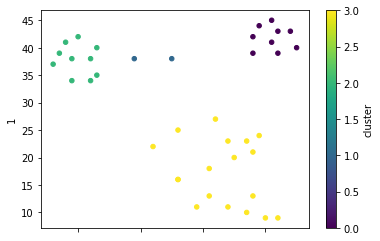

In [53]:
k=4

sys.argv = f"dbscan.py ./data/4clusters.csv {k}".split(" ")
if __name__ == "__main__":
    if len(sys.argv) == 3:
        _, datafile, k = sys.argv
    else:
        print("Usage: python3 dbscan.py <datafile.csv> <epsilon> <numPoints>")
        exit(1)
        
    k = int(k)
    df_full, restr = readFiles(datafile)
    df, dropped = restrictdf(df_full, restr, getDropped=True)
    df = df
    centroids = initCentroids(df,k)
    df, centroids = kmeans_lite(df, centroids, euclideanDist)
    df.plot.scatter(x=0,y=1,c='cluster',colormap='viridis')    
#     print(dropped)
#     df = df.join(dropped)
#     print(df.to_markdown())
    printClusterInfo(analyzeClusters(df, centroids, euclideanDist), extraCols = dropped)